## CNN ON CUSTOM DATASET

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline  
print ("CURRENT TF VERSION IS [%s]" % (tf.__version__))
print ("PACKAGES LOADED")

CURRENT TF VERSION IS [1.0.1]
PACKAGES LOADED


## LOAD DATA

In [2]:
# LOAD DATA
cwd = os.getcwd()
loadpath = cwd + "/data/custom_data.npz"
l = np.load(loadpath)
print (l.files)

# PARSE LOADED DATA
trainimg   = l['trainimg']
trainlabel = l['trainlabel']
testimg    = l['testimg']
testlabel  = l['testlabel']
imgsize    = l['imgsize']
categories = l['categories']
use_gray   = l['use_gray']
if use_gray:
    nimgch = 1
else:
    nimgch = 3
ntrain = trainimg.shape[0]
nclass = trainlabel.shape[1]
dim    = trainimg.shape[1]
ntest  = testimg.shape[0]
print ("%d TRAIN IMAGES" % (ntrain))
print ("%d TEST IMAGES" % (ntest))
print ("%d DIMENSIONAL INPUT" % (dim))
print ("%d CLASSES" % (nclass))
print (imgsize)
print (categories)

['trainlabel', 'imgsize', 'trainimg', 'testimg', 'testlabel', 'use_gray', 'categories']
544 TRAIN IMAGES
137 TEST IMAGES
4096 DIMENSIONAL INPUT
4 CLASSES
[64 64]
['Terminator' 'Koizumi' 'Putin' 'Bush']


In [3]:
# NETWORK TOPOLOGIES
n_input    = dim
n_channel  = 64 
n_classes  = nclass  

# INPUTS AND OUTPUTS
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])
    
# NETWORK PARAMETERS
stddev = 0.1
weights = {
    'c1': tf.Variable(tf.random_normal([7, 7, nimgch, n_channel], stddev=stddev)),
    'c2': tf.Variable(tf.random_normal([7, 7, n_channel, 128], stddev=stddev)),
    'd1': tf.Variable(tf.random_normal([dim//16*128, n_classes], stddev=stddev))
}
biases = {
    'c1': tf.Variable(tf.random_normal([n_channel], stddev=stddev)),
    'c2': tf.Variable(tf.random_normal([128], stddev=stddev)),
    'd1': tf.Variable(tf.random_normal([n_classes], stddev=stddev))
}
print ("NETWORK READY")

NETWORK READY


In [4]:
# MODEL
def CNN(_x, _w, _b):
    # RESHAPE
    _x_r = tf.reshape(_x, shape=[-1, imgsize[0], imgsize[1], nimgch])
    # CONVOLUTION
    _conv1 = tf.nn.conv2d(_x_r, _w['c1'], strides=[1, 1, 1, 1], padding='SAME')
    # ADD BIAS
    _conv2 = tf.nn.bias_add(_conv1, _b['c1'])
    # RELU
    _conv3 = tf.nn.relu(_conv2)
    # MAX-POOL
    _pool  = tf.nn.max_pool(_conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    temp = tf.nn.conv2d(_pool, _w['c2'], strides=[1, 1, 1, 1], padding='SAME')
    temp = tf.nn.bias_add(temp, _b['c2'])
    temp = tf.nn.relu(temp)
    temp = tf.nn.max_pool(temp, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    # VECTORIZE
    _dense = tf.reshape(temp, [-1, _w['d1'].get_shape().as_list()[0]])
    # DENSE
    _logit = tf.add(tf.matmul(_dense, _w['d1']), _b['d1'])
    _out = {
        'x_r': _x_r, 'conv1': _conv1, 'conv2': _conv2, 'conv3': _conv3
        , 'pool': _pool, 'dense': _dense, 'logit': _logit
    }
    return _out

# PREDICTION
cnnout = CNN(x, weights, biases)

# LOSS AND OPTIMIZER
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        labels=y, logits=cnnout['logit']))
optm = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost) 
corr = tf.equal(tf.argmax(cnnout['logit'], 1), tf.argmax(y, 1))    
accr = tf.reduce_mean(tf.cast(corr, "float"))

# INITIALIZER
init = tf.global_variables_initializer()
print ("FUNCTIONS READY")

FUNCTIONS READY


## RUN

Epoch: 010/050 cost: 0.079991972
 TRAIN ACCURACY: 0.980
 TEST ACCURACY: 0.905
 13 MISSED


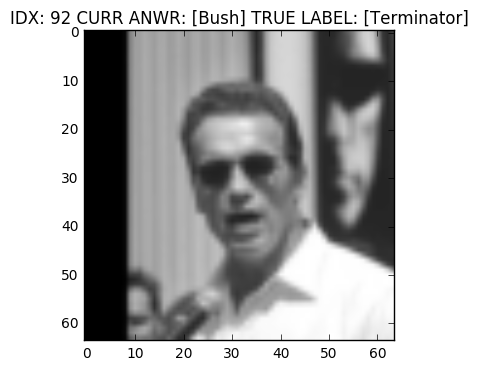

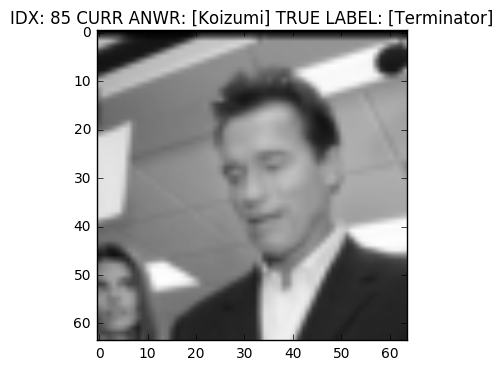

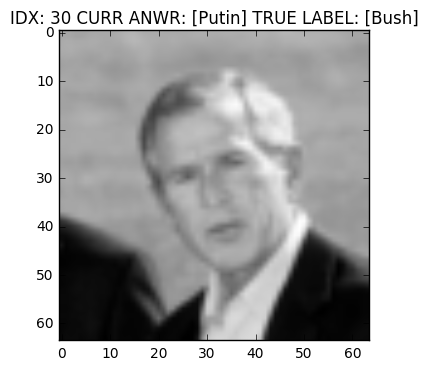

Epoch: 020/050 cost: 0.005416898
 TRAIN ACCURACY: 1.000
 TEST ACCURACY: 0.942
 8 MISSED


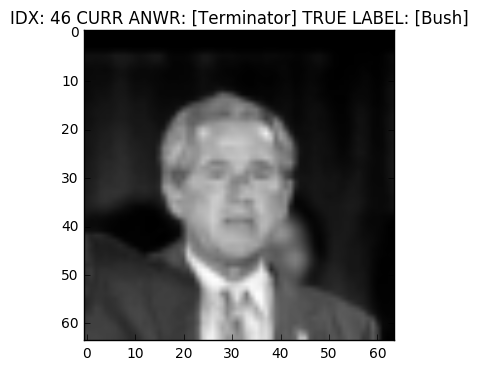

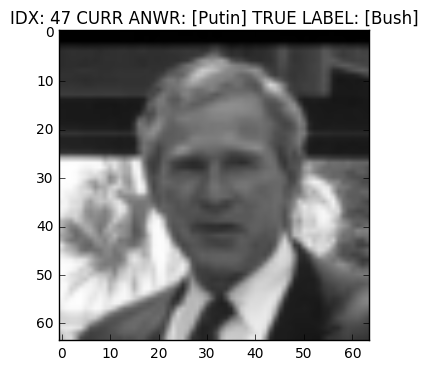

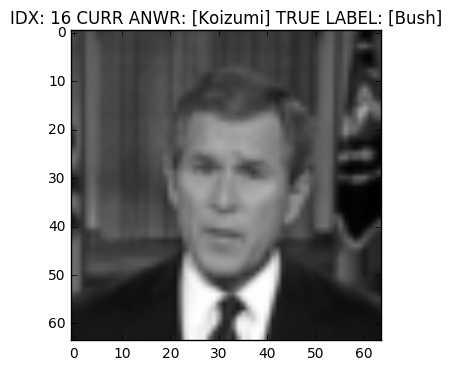

Epoch: 030/050 cost: 0.002713238
 TRAIN ACCURACY: 1.000
 TEST ACCURACY: 0.949
 7 MISSED


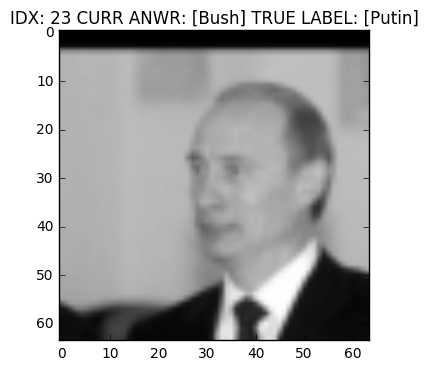

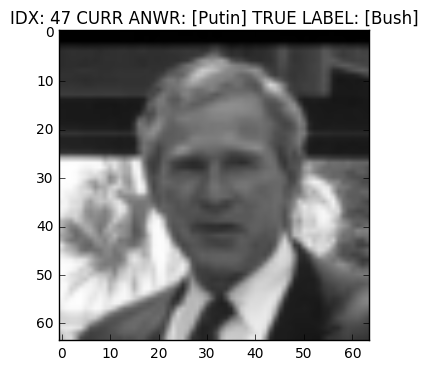

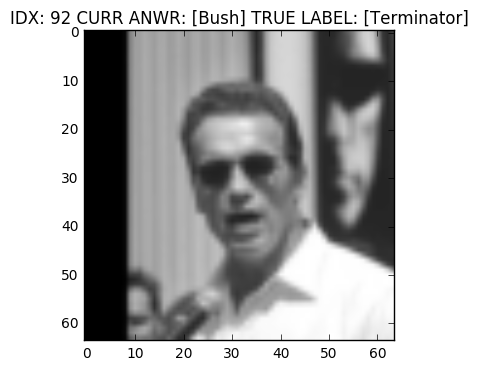

Epoch: 040/050 cost: 0.001600010
 TRAIN ACCURACY: 1.000
 TEST ACCURACY: 0.949
 7 MISSED


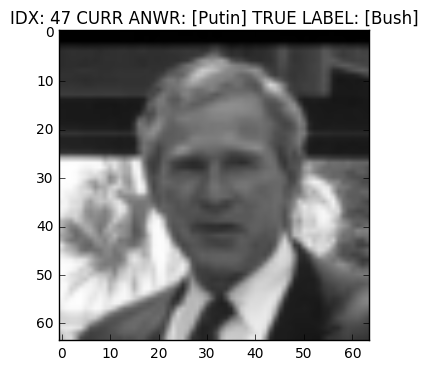

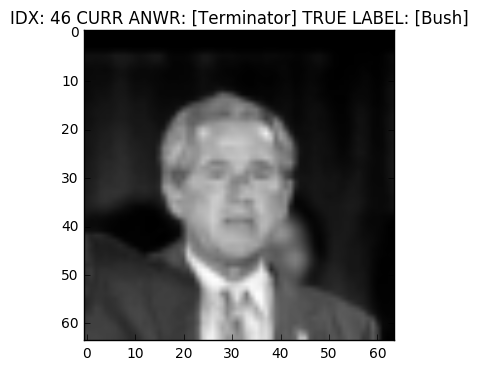

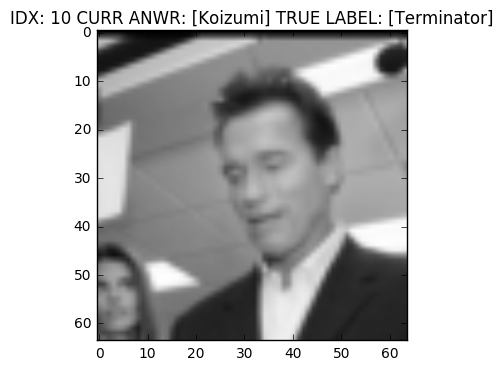

Epoch: 050/050 cost: 0.000865572
 TRAIN ACCURACY: 1.000
 TEST ACCURACY: 0.956
 6 MISSED


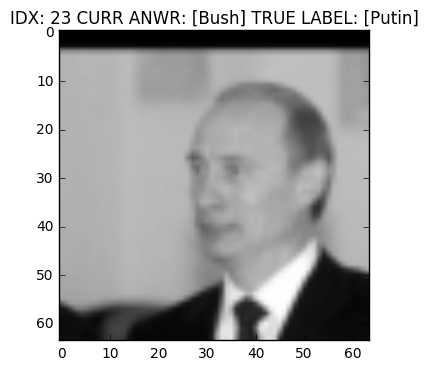

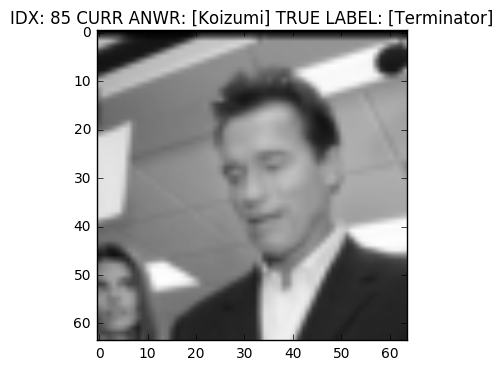

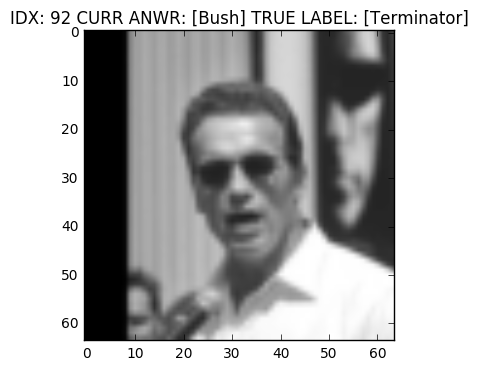

OPTIMIZATION FINISHED


In [5]:
# PARAMETERS
training_epochs = 50
batch_size      = 100
disp_each       = 10
plot_each       = 10
# LAUNCH THE GRAPH
sess = tf.Session()
sess.run(init)
# OPTIMIZE
for epoch in range(training_epochs):
    total_batch = int(ntrain/batch_size)
    randpermlist = np.random.permutation(ntrain)
    sun_cost = 0.
    for i in range(total_batch):
        randidx  = randpermlist[i*batch_size:min((i+1)*batch_size, ntrain-1)]
        batch_xs = trainimg[randidx, :]
        batch_ys = trainlabel[randidx, :]                
        feeds = {x: batch_xs, y: batch_ys}
        sess.run(optm, feed_dict=feeds)
        sun_cost += sess.run(cost, feed_dict=feeds)
    avg_cost = sun_cost / total_batch
        
    # DISPLAY
    if (epoch+1) % disp_each == 0 or epoch == training_epochs-1:
        print ("Epoch: %03d/%03d cost: %.9f" % (epoch+1, training_epochs, avg_cost))
        feeds = {x: batch_xs, y: batch_ys}
        train_acc = sess.run(accr, feed_dict=feeds)
        print (" TRAIN ACCURACY: %.3f" % (train_acc))
        feeds = {x: testimg, y: testlabel}
        test_acc = sess.run(accr, feed_dict=feeds)
        print (" TEST ACCURACY: %.3f" % (test_acc))
        
    # PLOT
    if (epoch+1) % plot_each == 0 or epoch == training_epochs-1:
        ntemp = int(ntest/batch_size) + 1 
        missidxlist = []
        for ii in range(ntemp):
            iii = np.arange(ii*batch_size, min(ntest, (ii+1)*batch_size))
            feeds = {x: testimg[iii, :], y: testlabel[iii, :]}
            missidx = np.where(sess.run(corr, feed_dict=feeds) == 0)[0]
            missidxlist = np.concatenate((missidxlist, iii[missidx]))
        nmiss = len(missidxlist)
        print (" %d MISSED" % (nmiss))
        # PLOT MISSCLASSIFIED (UPTO THREE)
        missidxlist = np.random.permutation(missidxlist.astype(int))
        selmissidx  = missidxlist[:min(3, nmiss)].astype(int)
        feeds_miss  = {x: testimg[selmissidx, :], y: testlabel[selmissidx, :]}
        pred_miss   = sess.run(cnnout['logit'], feed_dict=feeds_miss)
        answ_miss   = np.argmax(pred_miss, 1)
        answ_corr   = np.argmax(testlabel[selmissidx, :], 1)
        for idx in range(len(selmissidx)):
            cidx = selmissidx[idx]
            anw  = answ_miss[idx]
            ref  = answ_corr[idx]
            if use_gray != 0:
                currimg = np.reshape(testimg[cidx, :], (imgsize[0], imgsize[1]))
                plt.imshow(currimg, cmap='gray')
            else:
                currimg = np.reshape(testimg[cidx, :], (imgsize[0], imgsize[1], -1))
                plt.imshow(currimg)
            anw_category = categories[anw]
            ref_category = categories[ref]
            title_string = ("IDX: %d CURR ANWR: [%s] TRUE LABEL: [%s]" 
                % (cidx, anw_category, ref_category))
            plt.title(title_string) 
            plt.show() 
print ("OPTIMIZATION FINISHED")